In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader as web
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [11]:
# Các hàm định nghĩa
# Dinh nghia ham ACF va PACF
def sACF(y,K):
    T = len(y)
    ytb = y.mean()
    ACF = np.zeros(K)
    c0 = np.sum((y-ytb)**2)/T
    for k in range(1, K+1):
        ck = np.sum((y-ytb)[:T-k]*(y-ytb)[k:T])/T
        ACF[k-1]= ck/c0
    
    se_ACF = np.zeros(K)
    for i in range(K):
        se_ACF[i] = np.sqrt(1/T*(1+2*np.sum(ACF[:i]**2)))
    return ACF, se_ACF

def sPACF(y,K):
    T = len(y)
    #Lay day dau tien
    ACF = sACF(y,K)[0]
    PACF = np.zeros(K)
    for m in range(1,K+1):
        P = np.eye(m)
        for i in range(m):
            for j in range(i):
                P[i,j] = ACF[i-j-1]
            for j in range(i+1,m):
                P[i,j] = ACF[j-i-1];
        PACF[m-1] = np.linalg.solve(P,ACF[:m])[-1]
    se_PACF = np.array([1/np.sqrt(T) for i in range(K)])
    return PACF, se_PACF

# Tính thống kê Q(k)
def Qstat(at,k):
    at_ACF = sACF(at,k)[0]
    n = len(at)
    Qstat = 0
    for i in range(k):
        Qstat += n*(n+2)*at_ACF[i]**2/(n-i-1)
    return Qstat

In [12]:
data = pd.read_excel('data.xlsx')
y = data['Readings'].values
data.head(2)

,Periods,Readings
0,1,6.14
1,2,7.25


In [13]:
#TB, ĐỘ LỆCH CHUẨN
n = len(y)
ytb = y.mean()
s_y = y.std()
print("Ytb=", ytb)
print("Độ lệch chuẩn=" , s_y)

Ytb= 19.849
Độ lệch chuẩn= 8.372194037407398


a) Vẽ biểu đồ dữ liệu về y(t)

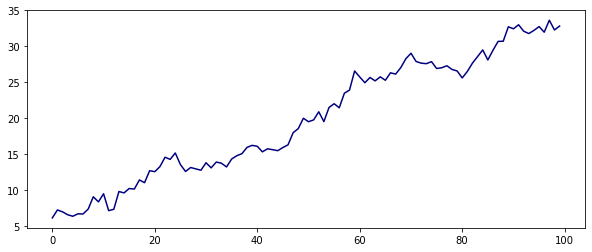

In [14]:
plt.subplots(figsize = (10,4))
plt.plot(y, color='navy')
plt.show()

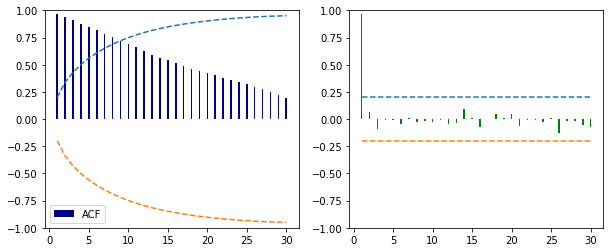

In [15]:
# TÍnh và vẽ biểu đồ tương quan ACF và PACF
K = 30
ACF, se_ACF = sACF(y,K)
PACF, se_PACF = sPACF(y,K)

fig, ax = plt.subplots(1,2,figsize = (10,4))
x = np.arange(1, K+1)
ax[0].bar(x,ACF, color='navy', width= 0.2 , label="ACF")
ax[0].plot(x, 2*se_ACF, linestyle='dashed')
ax[0].plot(x,-2*se_ACF, linestyle='dashed')
ax[0].set_ylim([-1,1])
ax[0].legend()

ax[1].bar(x,PACF, color='green', width= 0.2 , label="PACF")
ax[1].plot(x, 2*se_PACF, linestyle='dashed')
ax[1].plot(x,-2*se_PACF, linestyle='dashed')
ax[1].set_ylim([-1,1])
ax[0].legend()

plt.show()

Nhận xét: ACF giảm dần tuyến tính, chuỗi tỉ giá là quá trình không dừng => lấy sai phân chuỗi  𝑦𝑡  và khảo sát

In [16]:
# Tính sai phân
dy = np.diff(y)

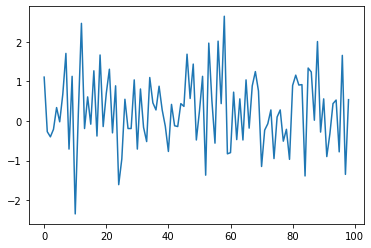

In [17]:
plt.plot(dy)

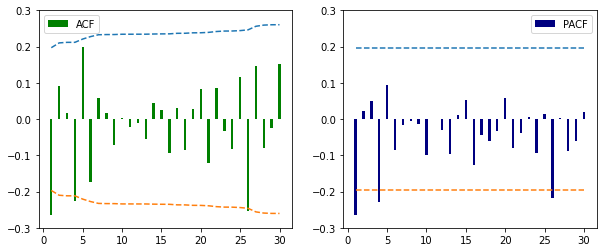

In [18]:
ACF, se_ACF = sACF(dy,K)
PACF, se_PACF = sPACF(dy,K)
# Vẽ đồ thị
fig,ax = plt.subplots(1,2,figsize = (10,4))
x = np.arange(1,K+1)
ax[0].bar(x, ACF, color='green', width = 0.3, label='ACF')
ax[0].plot(x, 1.96*se_ACF, linestyle='dashed')
ax[0].plot(x, -1.96*se_ACF, linestyle='dashed')
ax[0].set_ylim([-0.3, 0.3])
ax[0].legend()

ax[1].bar(x, PACF, color='navy', width = 0.3, label='PACF')
ax[1].plot(x, 1.96*se_PACF, linestyle='dashed')
ax[1].plot(x, -1.96*se_PACF, linestyle='dashed')
ax[1].set_ylim([-0.3, 0.3])
ax[1].legend()
plt.show()

Từ biểu đồ PACF, ta nhận định mô hình MA(1) có thể phù hợp với dữ liệu này

b) Lựa chọn mô hình ARIMA phù hợp với chuỗi thời gian 𝑦 𝑡 và ước lượng các tham
số của mô hình

Mô hình MA(1) có dạng: $y_t = a_t - \phi a_{t-1}$

In [19]:
# Ước lượng mô hình
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
ydata = y[1:]
N = len(ydata)
X = np.stack([np.ones(N), y[:-1]]).T
model.fit(X,ydata)
theta,phi = model.coef_
print('phi = ', phi)
print('theta0 = ',theta)
print(f'Mô hình có dạng: y(t) = {theta} + {phi} y(t-1)+a(t)')
#Sai số tiêu chuẩn:
at= ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(at)-1))
print('sigma = ', sigma)

phi =  0.992369802712581
theta0 =  0.41994702546287627
Mô hình có dạng: y(t) = 0.41994702546287627 + 0.992369802712581 y(t-1)+a(t)
sigma =  0.9262899692613259


c) Đánh giá mô hình bằng thống kê Q

In [22]:
# Đánh giá mô hình bằng hệ số xác định R^2
SE = np.sum(at**2)
ST = np.sum((ydata-ydata.mean())**2)
R2 = 1-SE/ST
print('SE = ', SE)
print('ST = ', ST)
print ('R^2= ',R2)
# Tính thống kê Q(k)
k = 12
print('Giá trị thống kê Q(%d)= %f'%(k,Qstart(at,k)))

SE =  84.08528450110651
ST =  6819.5282686868695
R^2=  0.9876699265421042
Giá trị thống kê Q(12)= 21.398641
